In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import plotly.express as px
from scipy.interpolate import BSpline
import plotly.graph_objects as go


## SiLU

In [55]:

# Define the SiLU activation (basis function)
class SiLU(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

In [56]:
silu = SiLU()
#generate some data to test the activation function
x = np.linspace(-10, 10, 100)
y = silu(torch.tensor(x)).detach().numpy()
# Create the plot
fig = px.line(x=x, y=y, title="SiLU Activation Function")
# Ensure the plot is square
fig.update_layout(
    width=600,  # Width of the plot
    height=600,  # Height of the plot
    xaxis=dict(scaleanchor="y", scaleratio=1)  # Equal aspect ratio
)

fig.show()

Alternative is nn.SiLU in Pytorch

In [58]:
silu = nn.SiLU()
#generate some data to test the activation function
x = np.linspace(-10, 10, 100)
y = silu(torch.tensor(x)).detach().numpy()
# Create the plot
fig = px.line(x=x, y=y, title="SiLU Activation Function")
# Ensure the plot is square
fig.update_layout(
    width=600,  # Width of the plot
    height=600,  # Height of the plot
    xaxis=dict(scaleanchor="y", scaleratio=1)  # Equal aspect ratio
)

fig.show()

## B-Spline

In [59]:
def B_batch(x, grid, k=0):
    '''
    evaludate x on B-spline bases
    
    Args:
    -----
        x : 2D torch.tensor
            inputs, shape (number of splines, number of samples)
        grid : 2D torch.tensor
            grids, shape (number of splines, number of grid points)
        k : int
            the piecewise polynomial order of splines.
    
    Returns:
    --------
        spline values : 3D torch.tensor
            shape (batch, in_dim, G+k). G: the number of grid intervals, k: spline order.
      
    Example
    -------
    >>> from kan.spline import B_batch
    >>> x = torch.rand(100,2)
    >>> grid = torch.linspace(-1,1,steps=11)[None, :].expand(2, 11)
    >>> B_batch(x, grid, k=3).shape
    '''
    
    x = x.unsqueeze(dim=2)
    grid = grid.unsqueeze(dim=0)
    
    if k == 0:
        value = (x >= grid[:, :, :-1]) * (x < grid[:, :, 1:])
    else:
        B_km1 = B_batch(x[:,:,0], grid=grid[0], k=k - 1)
        
        value = (x - grid[:, :, :-(k + 1)]) / (grid[:, :, k:-1] - grid[:, :, :-(k + 1)]) * B_km1[:, :, :-1] + (
                    grid[:, :, k + 1:] - x) / (grid[:, :, k + 1:] - grid[:, :, 1:(-k)]) * B_km1[:, :, 1:]
    
    # in case grid is degenerate
    value = torch.nan_to_num(value)
    return value



def coef2curve(x_eval, grid, coef, k, device="cpu"):
    '''
    converting B-spline coefficients to B-spline curves. Evaluate x on B-spline curves (summing up B_batch results over B-spline basis).
    
    Args:
    -----
        x_eval : 2D torch.tensor
            shape (batch, in_dim)
        grid : 2D torch.tensor
            shape (in_dim, G+2k). G: the number of grid intervals; k: spline order.
        coef : 3D torch.tensor
            shape (in_dim, out_dim, G+k)
        k : int
            the piecewise polynomial order of splines.
        device : str
            devicde
        
    Returns:
    --------
        y_eval : 3D torch.tensor
            shape (number of samples, in_dim, out_dim)
        
    '''
    
    b_splines = B_batch(x_eval, grid, k=k)
    y_eval = torch.einsum('ijk,jlk->ijl', b_splines, coef.to(b_splines.device))
    
    return y_eval


def curve2coef(x_eval, y_eval, grid, k, lamb=1e-8):
    '''
    converting B-spline curves to B-spline coefficients using least squares.
    
    Args:
    -----
        x_eval : 2D torch.tensor
            shape (in_dim, out_dim, number of samples)
        y_eval : 2D torch.tensor
            shape (in_dim, out_dim, number of samples)
        grid : 2D torch.tensor
            shape (in_dim, grid+2*k)
        k : int
            spline order
        lamb : float
            regularized least square lambda
            
    Returns:
    --------
        coef : 3D torch.tensor
            shape (in_dim, out_dim, G+k)
    '''
    batch = x_eval.shape[0]
    in_dim = x_eval.shape[1]
    out_dim = y_eval.shape[2]
    n_coef = grid.shape[1] - k - 1
    mat = B_batch(x_eval, grid, k)
    mat = mat.permute(1,0,2)[:,None,:,:].expand(in_dim, out_dim, batch, n_coef)
    y_eval = y_eval.permute(1,2,0).unsqueeze(dim=3)
    device = mat.device
    
    #coef = torch.linalg.lstsq(mat, y_eval,
                             #driver='gelsy' if device == 'cpu' else 'gels').solution[:,:,:,0]
        
    XtX = torch.einsum('ijmn,ijnp->ijmp', mat.permute(0,1,3,2), mat)
    Xty = torch.einsum('ijmn,ijnp->ijmp', mat.permute(0,1,3,2), y_eval)
    n1, n2, n = XtX.shape[0], XtX.shape[1], XtX.shape[2]
    identity = torch.eye(n,n)[None, None, :, :].expand(n1, n2, n, n).to(device)
    A = XtX + lamb * identity
    B = Xty
    coef = (A.pinverse() @ B)[:,:,:,0]
    
    return coef


def extend_grid(grid, k_extend=0):
    '''
    extend grid
    '''
    h = (grid[:, [-1]] - grid[:, [0]]) / (grid.shape[1] - 1)

    for i in range(k_extend):
        grid = torch.cat([grid[:, [0]] - h, grid], dim=1)
        grid = torch.cat([grid, grid[:, [-1]] + h], dim=1)

    return grid

In [60]:
x = torch.rand(100,2)
grid = torch.linspace(-1,1,steps=11)[None, :].expand(2, 11)
B_batch(x, grid, k=3).shape

torch.Size([100, 2, 7])

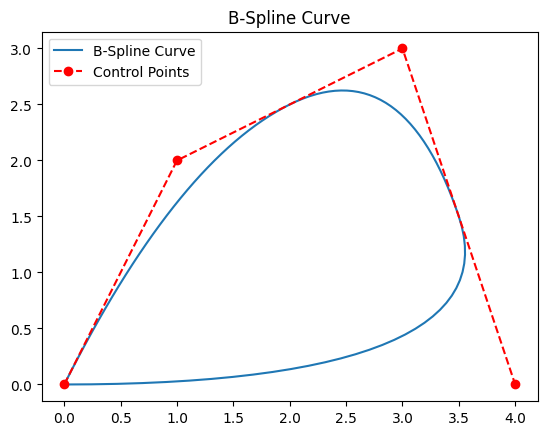

In [66]:
import numpy as np
import matplotlib.pyplot as plt

def bspline_basis_function(i, p, t, knot_vector):
    """
    Compute the B-spline basis function N_{i,p}(t) recursively.
    
    i : int
        Index of the basis function.
    p : int
        Degree of the basis function.
    t : float
        The parameter value.
    knot_vector : array_like
        The knot vector.
    """
    if p == 0:
        return 1.0 if knot_vector[i] <= t < knot_vector[i+1] else 0.0
    else:
        left = 0.0
        if knot_vector[i+p] != knot_vector[i]:
            left = ((t - knot_vector[i]) / (knot_vector[i+p] - knot_vector[i])) * bspline_basis_function(i, p-1, t, knot_vector)
        
        right = 0.0
        if knot_vector[i+p+1] != knot_vector[i+1]:
            right = ((knot_vector[i+p+1] - t) / (knot_vector[i+p+1] - knot_vector[i+1])) * bspline_basis_function(i+1, p-1, t, knot_vector)
        
        return left + right

def evaluate_bspline(control_points, degree, knot_vector, num_points=100):
    """
    Evaluate a B-spline curve.
    
    control_points : array_like
        Control points.
    degree : int
        Degree of the B-spline.
    knot_vector : array_like
        Knot vector.
    num_points : int, optional
        Number of points to evaluate on the B-spline curve.
    """
    n = len(control_points) - 1
    curve = np.zeros((num_points, control_points.shape[1]))
    t_values = np.linspace(knot_vector[degree], knot_vector[-degree-1], num_points)
    
    for idx, t in enumerate(t_values):
        for i in range(n + 1):
            basis_value = bspline_basis_function(i, degree, t, knot_vector)
            curve[idx] += basis_value * control_points[i]
    
    return curve

# Example Usage
degree = 2
control_points = np.array([[0, 0], [1, 2], [3, 3], [4, 0]])
knot_vector = np.array([0, 0, 0, 1, 2, 3, 3, 3])

# Generate the B-spline curve
curve = evaluate_bspline(control_points, degree, knot_vector)

# Plot the B-spline curve
plt.plot(curve[:, 0], curve[:, 1], label="B-Spline Curve")
plt.plot(control_points[:, 0], control_points[:, 1], 'ro--', label="Control Points")
plt.legend()
plt.title("B-Spline Curve")
plt.show()